In [79]:
import sys
sys.path.append('../')

In [80]:
import pennylane as qml 
from pennylane import numpy as np 
import matplotlib.pyplot as plt 
from main import Rot_ansatz, VarFourier

In [81]:
num_qubits = 4

In [82]:
def init_state():
    pass 

In [83]:
var_state_class = Rot_ansatz(num_qubits)
var_state = var_state_class.construct_circuit

num_layers = 3
num_params = var_state_class.num_params
params_init = np.random.randn( num_layers, 
                                num_params )

In [84]:
device = qml.device( "lightning.qubit", 
                    wires=num_qubits)

varqft = VarFourier( num_qubits,
                    lambda x : x**2/2,
                    lambda p : p**2/2,
                    device,
                    var_state  = var_state,
                    init_state = init_state
                    )

In [85]:
val, vec = varqft.min_energy_eigens()
val 

0.5000000011276804

In [86]:
import optax
import jax

max_iterations = 1000
conv_tol = 1e-04

opt = optax.adam(learning_rate=0.5) # ADAM and SPSA are recommended on García-Molina et. al.

In [87]:
cost_fn = varqft.energy_eval
grad_fn = varqft.energy_grad
cost_fn( params_init )

7.150292612487525

In [88]:
param = np.copy(params_init)
opt_state = opt.init(params_init)

Params   = [param]
Energies = [cost_fn(param)]

for n in range(max_iterations):

    gradient = grad_fn(np.copy(param))
    updates, opt_state = opt.update(gradient, opt_state)
    param = optax.apply_updates(param, updates)

    Params.append(param)
    Energies.append(cost_fn(param))

    conv = np.abs(Energies[-1] - Energies[-2])

    if n % 2 == 0:
        print(f"Step = {n},  Energy = {Energies[-1]:.8f}")

    if conv <= conv_tol:
        break

Step = 0,  Energy = 11.12996674
Step = 2,  Energy = 5.45628166
Step = 4,  Energy = 4.45159912
Step = 6,  Energy = 3.31269789
Step = 8,  Energy = 2.65597153
Step = 10,  Energy = 2.18786526
Step = 12,  Energy = 1.92281795
Step = 14,  Energy = 1.87644601
Step = 16,  Energy = 1.96873415
Step = 18,  Energy = 1.67218280
Step = 20,  Energy = 1.71542203
Step = 22,  Energy = 1.56907964
Step = 24,  Energy = 1.34357345
Step = 26,  Energy = 1.22572386
Step = 28,  Energy = 1.24653041
Step = 30,  Energy = 1.19420671
Step = 32,  Energy = 1.16332495
Step = 34,  Energy = 1.03958857
Step = 36,  Energy = 1.01804149
Step = 38,  Energy = 0.88869047
Step = 40,  Energy = 0.80419159
Step = 42,  Energy = 0.69297469
Step = 44,  Energy = 0.68220961
Step = 46,  Energy = 0.58697814
Step = 48,  Energy = 0.59828287
Step = 50,  Energy = 0.56255776
Step = 52,  Energy = 0.56560045
Step = 54,  Energy = 0.56851548
Step = 56,  Energy = 0.55044484
Step = 58,  Energy = 0.54848248
Step = 60,  Energy = 0.53329539
Step = 62,  

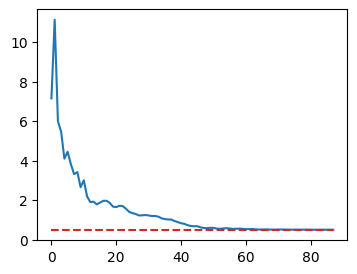

In [89]:
plt.figure( figsize=(4,3) ) 
plt.plot( Energies )
plt.hlines( val, 0, n+1, colors='tab:red', linestyles='--' ) 

In [90]:
def theo_state( params ):
    var_state( params )
    return qml.state()

final_state = qml.QNode( theo_state, device )(param)

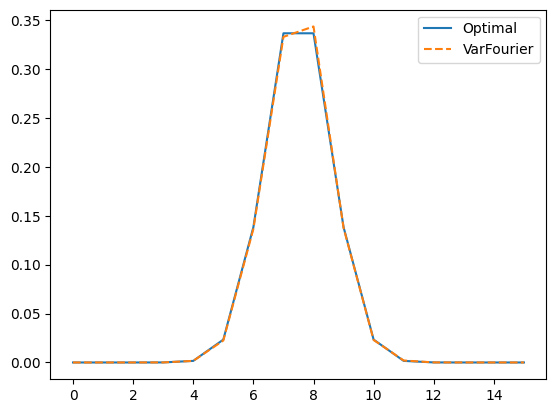

In [91]:
plt.plot( np.abs(vec)**2)
plt.plot( np.abs(final_state)**2, '--' )
plt.legend(['Optimal','VarFourier'])